# How to Open Machine Learning Input Products

For each detectid in the line emission database (detect_hdr2.h5) we have generated 100 pixel (200 Angstrom) by 9 pixel fiber cutouts of the weighted sum of all fibers used to measured the extracton as well as cutouts of the four brightest fibers contributing to the flux. We also include the 1D spectrum (this is the same product included in the Spectra table for the detect_hdr2.h5 file) and a 30 arcsec x 30 arcsec cutout of HSC r-band imaging for the detection in available.

In [1]:
import tables as tb
import numpy as np
import os.path as op

from astropy.table import Table, join, unique
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval

from hetdex_api.config import HDRconfig

In [20]:
from IPython.display import display, Javascript


In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
config = HDRconfig('hdr3')

## Pytables and hetdex_api.config provide an easy interface to the ML products

Labels are in:

In [4]:
labelfile = op.join( config.hdr_dir['hdr3'], 'catalogs','ml','ml-labels_3.0.0.tab')
label_tab = Table.read(labelfile, format='ascii')

In [5]:
t = Table( np.unique(label_tab['detectid'], return_counts=True))

In [6]:
t_uniq = unique( label_tab, keys='detectid')

### Label type breakdown. A few detectids can have two labels. You can choose which label to use

In [7]:
Table(np.unique(t_uniq['label'], return_counts=True))

label,col1
str9,int64
--,1560135
badamp,10000
badpix,9971
confirmed,9505
meteor,6827


In [8]:
np.array(np.unique(t_uniq['label']))

array(['0', 'badamp', 'badpix', 'confirmed', 'meteor'], dtype='<U9')

### This file has the summed fiber cutout image and invidual fiber cutout images as well as HSC r-band imaging if available. We also include the 1D extracted spectrum of the detection.

In [9]:
mlfile = op.join( config.hdr_dir['hdr3'], 'catalogs','ml','detect_ml_3.0.0.h5')
fileh = tb.open_file(mlfile, 'r') 

print('ML data product file is found at {}'.format(mlfile))

ML data product file is found at /home/jovyan/Hobby-Eberly-Telesco/hdr3/catalogs/ml/detect_ml_3.0.0.h5


Here is the hierarchical structure:

In [10]:
fileh

File(filename=/home/jovyan/Hobby-Eberly-Telesco/hdr3/catalogs/ml/detect_ml_3.0.0.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/FiberImages (Table(1582775,)) 'Fiber Cutout Images'
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "im_wave": Float32Col(shape=(100,), dflt=0.0, pos=1),
  "im_sum": Float32Col(shape=(9, 100), dflt=0.0, pos=2),
  "im_array": Float32Col(shape=(4, 9, 100), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (56,)
  autoindex := True
  colindexes := {
    "detectid": Index(9, fullshuffle, zlib(1)).is_csi=True}
/PhotImages (Table(1582775,)) 'Photometric Images'
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "im_phot": Float32Col(shape=(60, 60), dflt=0.0, pos=1),
  "im_phot_hdr": StringCol(itemsize=2880, shape=(), dflt=b'', pos=2)}
  byteorder := 'little'
  chunkshape := (60,)
  autoindex := True


# Open the 2 Summed Fiber Image

Because we have over 1 million detections in each table and each table contains several 2D arrays, the best way to navigate the file is by detectid. We have indexed all three tables based on the detectid so it is fast to query. But we do suggest you do it one by one. Please do not make copies of every component of this file on TACC anywhere on /work. Ideally you should learn to use the h5 files, otherwise pick smaller subsets of detections to work with.

In [11]:
detectid_obj = 3000001176

In [12]:
obj_data = fileh.root.FiberImages.read_where('detectid == detectid_obj')[0]

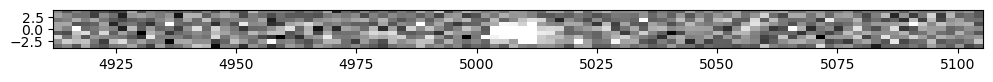

In [13]:
height=9 # in pixels
detectid = obj_data['detectid']
wave = obj_data['im_wave']
im_sum = obj_data['im_sum'] # this is the 2D summed image, 1st dim is height in fiber dims, 2nd dim is wave dim
im_array = obj_data['im_array'] # this is the 4 brightest fibers, 1st dim is fibers, 2nd dim is fiber dims, 3rd is wavelength
zscale = ZScaleInterval(contrast=0.5,krej=2.5)
vmin, vmax = zscale.get_limits(values=im_sum)
plt.figure(figsize=(12,5))
plt.imshow(im_sum,vmin=vmin, vmax=vmax,extent=[wave[0], wave[-1], -int(height/2.), int(height/2.)], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
plt.show()

In [14]:
# grab random 10K fiber images, this is slow. I recommend using stampede2 if you want to load in a lot of data at once

example_large_data_grab = False

if example_large_data_grab:
    rng = np.random.default_rng()
    sel_random = rng.integers(len(fileh.root.FiberImages), size=10000)

    im_array_table = Table(fileh.root.FiberImages.read())

    im_array_table[sel_random]

    im_array_random = fileh.root.FiberImages.read_coordinates(sel_random, 'im_array')

# Get Single Fiber cutouts for the four brightest fibers:

The 'im_array' column consists of fiber cutouts of the 4 brightest fibers

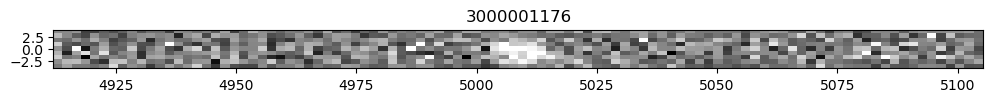

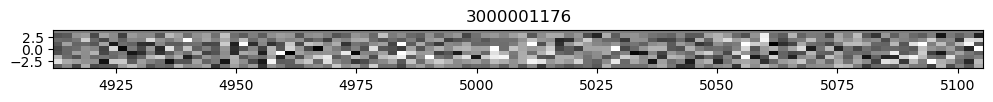

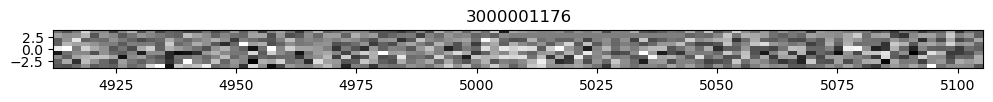

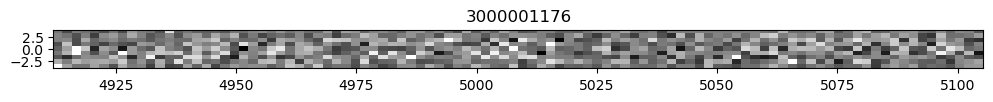

In [15]:
# plot each fiber for 4th object in example table
height=9

detectid = obj_data['detectid']
wave = obj_data['im_wave']
im_sum = obj_data['im_sum'] # this is the 2D summed image, 1st dim is height in fiber dims, 2nd dim is wave dim
im_array = obj_data['im_array'] # this is the 4 brightest fibers, 1st dim is fibers, 2nd dim is fiber dims, 3rd is wavelength
for im_i in np.arange(0,4):
    zscale = ZScaleInterval(contrast=0.5,krej=2.5)
    vmin, vmax = zscale.get_limits(values=im_array[im_i])
    plt.figure(figsize=(12,4))
    plt.title(str(detectid))
    plt.imshow(im_array[im_i],vmin=vmin, vmax=vmax,extent=[wave[0], wave[-1], -int(height/2.), int(height/2.)], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
    plt.show()

## Get the HSC 'r' band image if available

In [16]:
phot_image_table = Table(fileh.root.PhotImages.read_where('detectid == detectid_obj'))

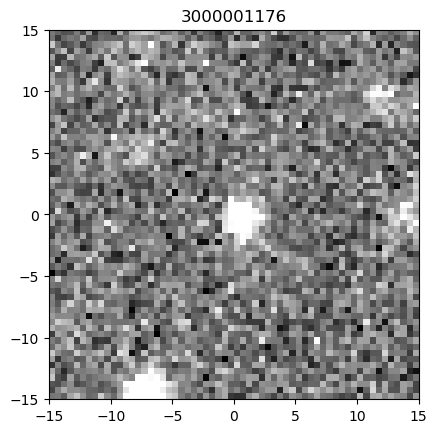

In [17]:
#Loop over the images
height=9
for row in phot_image_table:
    detectid = row['detectid']
    im_phot = row['im_phot'] # this is the r-band image
    zscale = ZScaleInterval(contrast=0.5,krej=2.5)
    vmin, vmax = zscale.get_limits(values=im_phot)
    plt.figure()
    plt.title(str(detectid))
    plt.imshow(im_phot,vmin=vmin, vmax=vmax,extent=[-15, 15, -15, 15], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
    plt.show()

## Get the Detection Spectrum

The 1D aperture Summed Spectrum is also contained in this file

In [18]:
spec_table = Table(fileh.root.Spec1D.read_where('detectid == detectid_obj'))

(3550.0, 5500.0)

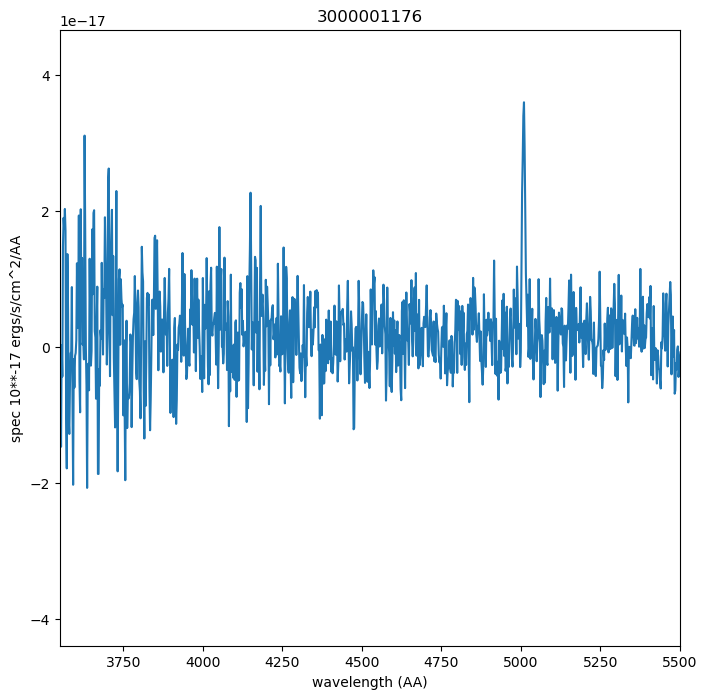

In [19]:
wave_rect = 2.0 * np.arange(1036) + 3470.0
plt.figure(figsize=(8,8))
plt.plot(wave_rect, spec_table['spec1D'][0]*10**-17 * u.erg / (u.cm ** 2 * u.s * u.AA))
plt.xlabel('wavelength (AA)')
plt.ylabel('spec 10**-17 ergs/s/cm^2/AA')
plt.title(detectid_obj)
plt.xlim(3550,5500)

## PLEASE CLOSE THE H5 FILE WHEN DONE

When done with an h5 file you should close it:

In [ ]:
fileh.close()

# Accessing the Line Flux Map images

In [ ]:
# If this fails. Load latest phot_tools function. You will need to update hetdex-api. Open a terminal
# cd software
# git stash
# git pull

from hetdex_tools.phot_tools import fit_circular_aperture



These line flux images are wavelength summed images created by summing along the wavelength dimension from -2 sigma to +2 sigma above and below the central wavelength

In [ ]:
fileh_im = tb.open_file(op.join( config.hdr_dir['hdr3'], 'catalogs/line_images_3.0.0.h5'),'r')

File structure breakdown. The "LineImages" table contains all necessary pieces to get the Line Flux map HDU. The "Info" table incluces the flux, flux_err, apcor and sn_im of measuring photometry in a r=1.5arcsec aperture. Note that the flux is underestimated from the fluxes in the HDR3 catalog by about a factor of 2 because we are using a small aperture radius that understamples the PSF. I recommend r=3 or 3.5 arcsec to get a more accurate total PS flux. The bkg_stddev is the standard deviation in the sigma-clipped intensity measured in an annulus at 5 to 7 arcsec around the detection. It is multiplied by the area of the central circular aperture. Astropy Photutils has some examples for more information (https://photutils.readthedocs.io/en/stable/aperture.html#sigma-clipped-median-within-a-circular-annulus). 

In [ ]:
fileh_im

### Will need to open detection h5 file

In [ ]:
deth5 = tb.open_file(config.detecth5, 'r')

In [ ]:
# This function converts the row data from the H5 file into an HDU FITS standard
def get_hdu(detectid_obj):
    im_data = fileh_im.root.LineImages.read_where('detectid == detectid_obj')[0]
    header = fits.Header.fromstring(im_data['header'])
    hdu = fits.PrimaryHDU(im_data['line_image'], header=header)
    hdu_error = fits.ImageHDU(im_data['line_image_err'], header=header)
    hdu_x = fits.ImageHDU(im_data['delta_ra'], header=header)
    hdu_y = fits.ImageHDU(im_data['delta_dec'], header=header)
    return fits.HDUList([hdu, hdu_error, hdu_x, hdu_y])

In [ ]:
# Function to plot line image. With option to change aperture size.
def plot_sn_im(detectid_obj,
               radius=1.5 * u.arcsec,
                annulus=[5, 7] * u.arcsec):
    
    det_info = deth5.root.Detections.read_where('detectid == detectid_obj')[0]
    linewidth = det_info['linewidth']
    wave_obj = det_info['wave']
    coords_obj = SkyCoord(det_info['ra'], det_info['dec'], unit='deg')
    shotid_obj = det_info['shotid']

    hdu = get_hdu(detectid_obj)
    
    plottitle = str(detectid_obj)
    flux, flux_err, bkg_stddev, apcor = fit_circular_aperture(
        hdu=hdu, coords=coords_obj, plot=True, plottitle=plottitle,
        radius=radius, annulus=annulus
    )
    plt.text(2, 2,
            "S/N={:3.2f}".format(flux.value / bkg_stddev.value),
            size=18,
            color="w",
    )

### Plot up some label examples

In [ ]:
sel_label = label_tab['label'] == 'badpix'#['badamp', 'badpix', 'confirmed', 'meteor']

for det in label_tab['detectid'][sel_label][1000:1100]:
    try:
        plt.figure()
        plot_sn_im(det)
    except:
        print('Failed for {}'.format(det))